# BG68: 感知机——深度学习的雏形

当我们试图了解传统的机器学习方法时，感知机(Perceptron)是一个浅显易懂的模型。或许在处理实际问题时很少使用感知机，但其设计原理和参数求解思路却是算法选择和设计时常用的参照。此外，熟知感知机的算法特点也能辅助了解深度学习(Deep Learning)模型的优缺点，并为进一步改进深度学习模型提供一些方向。

## 1. 感知机模型

对于一个普通的二分类(Binary Classification)问题，我们试图构建一个函数对输入的特征 $X$ 进行作用，输出正确的类别 $f(X)$。如果将正样本的类别标记为 “1”，负样本的类别标记为 “-1”，那么对于一个简单二分类问题的线性模型可以设计为：
$$
f(X) = sign (W X + b)
$$
其中，$W$ 和 $b$ 是参数，$sign()$ 为符号函数，即将非负的输入作用为 1，将负的输入作用为 -1，以上方程就是感知机模型的数学描述。

感知机模型可以处理高维的线性分类问题，即输入的特征 $X$ 是大于 2 维的向量。但是高维的数据不利于可视化，也不利于熟悉算法流程，以下就使用二维数据来演示感知机的所有要点。比如，采集一些样本点数据，表示为 
$$
\{(X_i, y_i), X_i\in R^2, y_i\in \{-1,1\}, i=1,2,...\}
$$

二维的特征数据可以很方便地在平面坐标系中表示出来，如下图中的左上图就是训练集(Trainset)中的数据样本点(Data Point)，右上图就是测试集中的数据样本点。训练集用于求解参数，测试集(Testset)用于评估模型的精度。通常，样本数据存在一些数值上的偏移，这些偏移本身并不携带信息，但是会导致在训练集上求解的模型在测试集上表现不佳，也就是泛化能力不足。为了解决这个问题，我们一般会对数据进行归一化(Normalization)操作，也就是下图中的左下图和右下图所示。

建立感知机模型也就是求解参数 $W$ 和 $b$，在坐标系上的表述就是寻找一条直线将两个类别的样本点区分开。

<IPython.core.display.Javascript object>


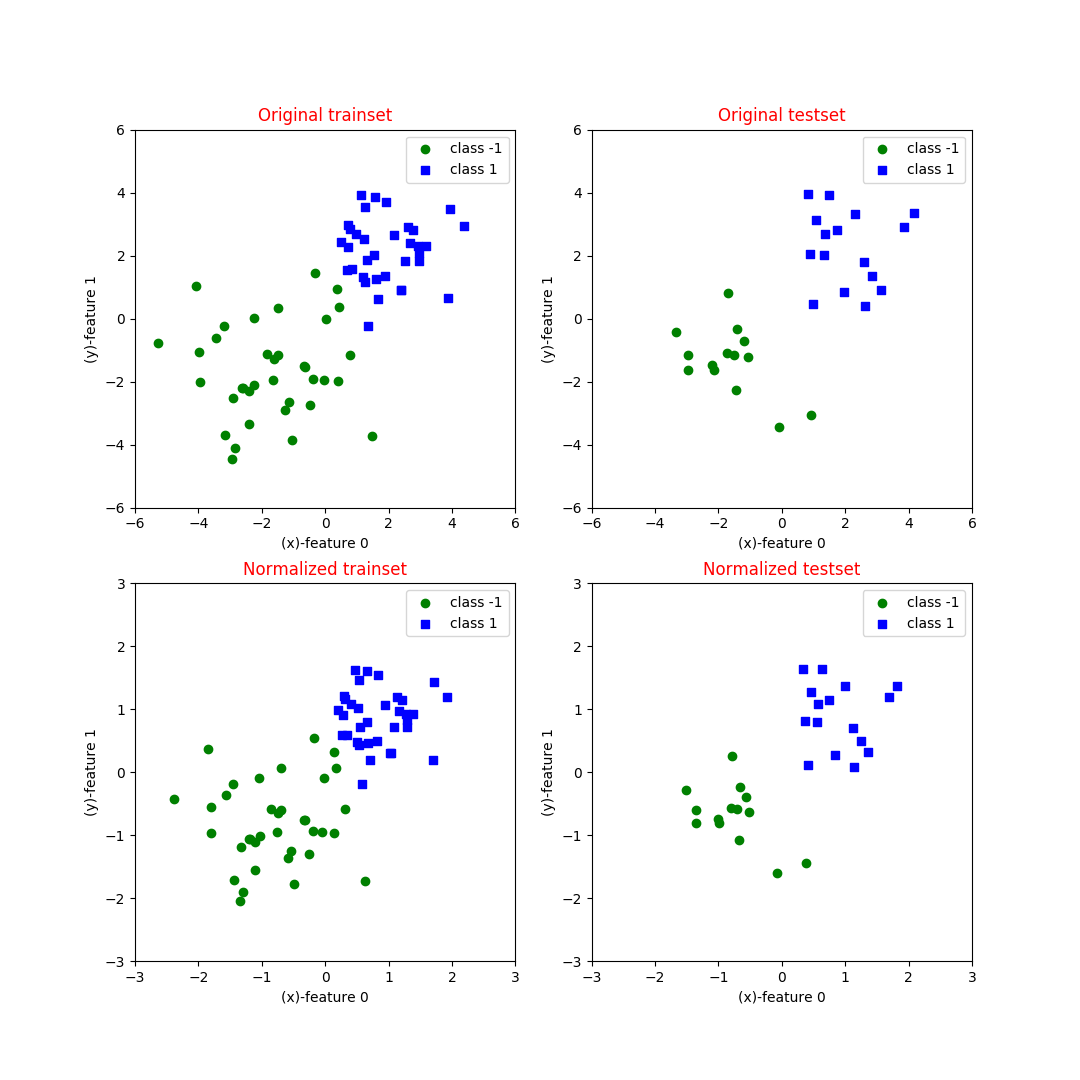

miu=[0.07       0.20385714], sigma=[2.24407919 2.27913724]
(70, 2) (30, 2)


In [1]:
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

# read data from file
data_path = '../data/bg68/data.txt'
data = np.genfromtxt(data_path, delimiter='\t')
X, Y = data[:, :2], data[:, 2].astype(dtype=np.int)
Y[Y==0] = -1
#shuffle
shuffle_idx = np.arange(Y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, Y = X[shuffle_idx], Y[shuffle_idx]
# split samples into trainset and testset
num_sample = X.shape[0]
num_train = int(num_sample*0.7)
X_train, X_test = X[:num_train, :], X[num_train:, :]
Y_train, Y_test = Y[:num_train], Y[num_train:]

def plot_samples(X, Y, max_x, title):
    plt.scatter(X[Y==-1, 0], X[Y==-1, 1], c='green', label='class -1', marker='o')
    plt.scatter(X[Y==1, 0], X[Y==1, 1], c='blue', label='class 1', marker='s')
    plt.title(title, color='red')
    plt.xlabel('(x)-feature 0')
    plt.ylabel('(y)-feature 1')
    plt.xlim((-max_x, max_x))
    plt.ylim((-max_x, max_x))
    plt.legend()

# plot
plt.figure(figsize=(10.8, 10.8))
plt.subplot(2,2,1)
plot_samples(X_train, Y_train, 6, 'Original trainset')
plt.subplot(2,2,2)
plot_samples(X_test, Y_test, 6, 'Original testset')

# normalization
miu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
print('miu={}, sigma={}'.format(miu,sigma))
X_train, X_test = (X_train - miu)/sigma, (X_test - miu)/sigma
print(X_train.shape, X_test.shape)
x_train_max = np.max(np.abs(X_train))
x_test_max = np.max(np.abs(X_test))
max_x = int(max(x_train_max, x_test_max)) + 1

# plot
plt.subplot(2,2,3)
plot_samples(X_train, Y_train, max_x, 'Normalized trainset')
plt.subplot(2,2,4)
plot_samples(X_test, Y_test, max_x, 'Normalized testset')

plt.savefig('../output/bg68/data.png', dpi=300, bbox_inches='tight')

## 2. 学习策略

学习策略就是参数调整的方式，即设计一种方法可以调整模型中的参数，以达到正确划分训练样本中的正负样本的目的。感知机的学习策略将重点放在“误分类”的样本点上。在当前模型参数的情况下，对分类预测错误的样本点构建损失函数，然后通过优化损失函数到最小值来调整模型参数。假设“误分类”样本点的集合为 $M$，则在 $M$ 上构建如下损失函数
$$
L(W, b) = -\sum_{X_i\in M}{y_i(W X_i + b)}
$$

由于该函数构建在“误分类”样本点上，则预测值 $f(X_i)$ 与 $y_i$ 的符号必定不相同，因此函数值为非负数。通过优化损失函数，使得“分类点”越来越少，最终没有“误分类”样本点，则表示优化完成。

## 3. 算法描述

对于“误分类”样本点集合M而言，损失函数 $L(W,b)$ 是关于 $W$ 和 $b$ 的线性函数，其梯度也就可以表示为
$$
\nabla_{W}L(W, b) = - \sum_{X_i\in M}{y_i X_i}\\
\nabla_{b}L(W, b) = - \sum_{X_i\in M}{y_i}
$$
随机选取一个误分类点，则参数更新的表达式可以表示为
$$
W \leftarrow W - (-\eta y_i X_i)\\
b \leftarrow b - (-\eta y_i)
$$
其中， $\eta$为学习率，数值在 0 到 1 之间。逐个选取“误分类”样本点来调整模型参数 $W$ 和 $b$，最终就可以达到没有“误分类”的情况。在实际操作时，要选择“误分类”点是一件比较麻烦的事情，我们可以将参数更新方程改造成如下
$$
e_i = y_i-f(X_i)\\
W \leftarrow W - (-\eta e_i X_i)\\
b \leftarrow b - (-\eta e_i))
$$
对于分类正确的样本点，$e_i=0$，则该调整无效，即这种参数调整虽然是在所有的样本点上进行，但是只对“误分类”的样本点有效。

按照这种方式优化得到最终的参数就可以建立一个感知机模型，模型的“分类超平面”在平面坐标系中表现为一条直线如下图所示。

In [2]:
import tensorflow as tf

feat_dim = X_train.shape[1]
class Model:
    
    def __init__(self):
        self.W = tf.Variable(tf.zeros((feat_dim, 1)), name='features')
        self.b = tf.Variable(tf.zeros((1)), name='target')
        
    def __call__(self, x):
        return tf.sign(tf.matmul(x, self.W) + self.b)
    
    def train(self, x, y, lr):
        error = y - self(x)
        # compute derivate of params
        dW = tf.reduce_mean(tf.constant(x*error), axis=0)
        db = tf.reduce_mean(error, axis=0)
        dW = tf.reshape(dW, shape=(2, 1))
        db = tf.reshape(db, shape=(1,))
        # update params
        self.W.assign_sub(-dW*lr)
        self.b.assign_sub(-db*lr)
        return self.W, self.b
    
model = Model()
X_train = X_train.astype(dtype=np.float32)
# train model
for epoch in range(5):
    for x, y in zip(X_train, Y_train):
        x = x.reshape((1, feat_dim))
        y = np.array(y, dtype=np.float32)
        y = y.reshape((1,))
        W, b = model.train(x, y, 1e-3)
print(model.W.numpy(), model.b.numpy())

[[0.00671099]
 [0.00267714]] [-0.003]


<IPython.core.display.Javascript object>


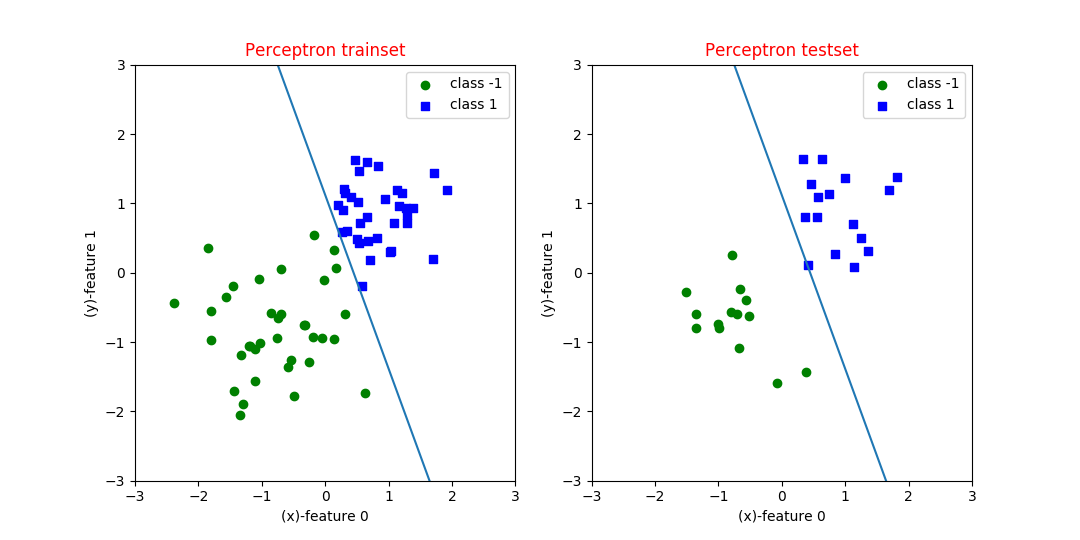

In [3]:
# plot param line
W, b = model.W.numpy(), model.b.numpy()
# w0*x+w1*y+b=0
x0 = -max_x
y0 = (-b[0]-W[0,0]*x0)/W[1,0]
x1 = max_x
y1 = (-b[0]-W[0,0]*x1)/W[1,0]
# plot
plt.figure(figsize=(10.8, 5.4))
plt.subplot(1,2,1)
plt.plot([x0, x1], [y0, y1], '-')
plot_samples(X_train, Y_train, max_x, 'Perceptron trainset')
plt.subplot(1,2,2)
plt.plot([x0, x1], [y0, y1], '-')
plot_samples(X_test, Y_test, max_x, 'Perceptron testset')

plt.savefig('../output/bg68/perceptron.png', dpi=300, bbox_inches='tight')


## 4. 问题讨论

随机选取一个样本点，使用梯度下降的方式进行参数求解的方法称为“随机梯度下降法”，这也是深度学习参数求解的一个基本方法。从感知机“分类平面”在训练集和测试集的几何位置可以看出，模型的泛化能力还不错。但是从学习策略的算法描述中可以发现，当没有“误分类”样本点时，参数调整就结束了，那么这样得到的参数仅仅是对训练集没有“误分类”，而不是最优化的参数。在这样的二分类问题中，“分类超平面”或者“分类直线”在距离最近的两个不同类别样本正中间则是最优的，感知机的学习策略显然是大概率无法达到最优化的要求。同样地，深度学习也是基本无法达到最优化，但是由于深度学习的参数空间极大，在一些局部极小处就能获得一个不错的精度和泛化能力。对于感知机而言，这样的非最优化结果会导致在应用时泛化能力不足。能够获得最优化参数的是支持向量机(SVM)，所以在实际应用时很少使用感知机，而是使用SVM代替。

从模型的数学形式可以看出，感知机只适用于线性可分的二分类问题，这一点对于具有这种形式的所有线性分类器都是适用的。如果需要处理非线性的问题，可以引入非线性的“核函数”来解决。这是传统机器学习中常用的策略。